#### NX-414: Brain-like computation and intelligence
##### TA: Alessandro Marin Vargas

# Week 6 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2024

You are required to submit your mini-projects by midnight on 07/05/24. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

<!-- You have until midnight of 07/05/23 to submit your mini-projects. You will be requested to upload a .zip file on Moodle containing your code and, specifically, the following:

- A one-page report (Report.pdf) detailing your investigation:
    - A table with model comparison: linear regression from stimuli, task-driven models (trained and random), data-driven models and your best model
    - A figure showing how the neural prediction changes across layer of a task-driven model
- A script (test.py) or notebook (test.ipynb) in which you show an example of your best model's usage on the validation set. -->

In [2]:
import sys
!{sys.executable} -m pip install gdown h5py

In [3]:
cd week6/

[Errno 2] No such file or directory: 'week6/'
/home/jupyter/week6


In [4]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)


Downloading...
From (original): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=a66909bd-bf0c-4afc-b588-9844796a2eb8
To: /home/jupyter/week6/IT_data.h5
100%|██████████| 384M/384M [00:01<00:00, 204MB/s]  


'IT_data.h5'

### Load the data

In [5]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [6]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


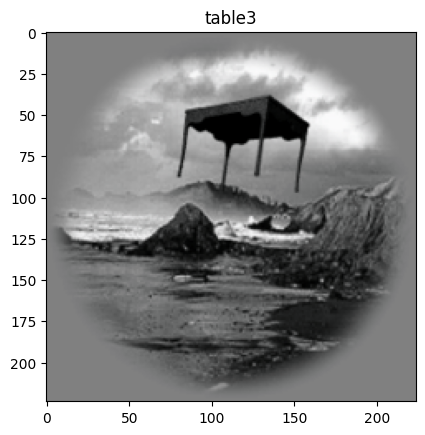

In [7]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

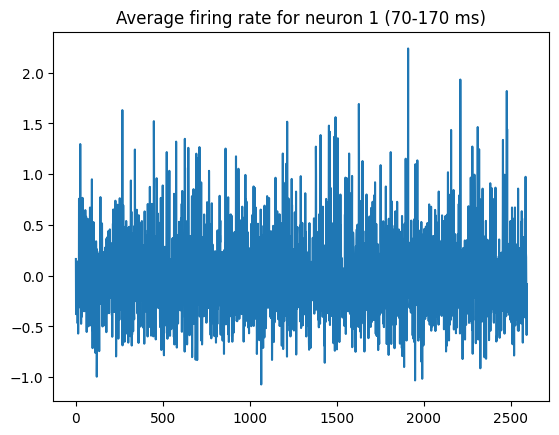

In [8]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

## Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

In [9]:
# Importing additional libraries
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV, train_test_split

In [10]:
# defining data
x_train, y_train, x_test, y_test = stimulus_train, spikes_train, stimulus_val, spikes_val

In [14]:
# data pre-processing steps
def preprocessing_func(x_train, x_test):
    x_flat_tr = x_train.reshape(x_train.shape[0],-1)
    X_tr = np.hstack([np.ones((x_flat_tr.shape[0],1)), x_flat_tr])
    x_flat_te = x_test.reshape(x_test.shape[0],-1)
    X_te = np.hstack([np.ones((x_flat_te.shape[0],1)), x_flat_te])
    return X_tr, X_te

def calculate_metrics(y_test,y_pred):
    correlations = np.array([np.corrcoef(y_test[:, i], y_pred[:, i])[0, 1] for i in range(y_test.shape[1])])
    
    explained_variance = np.zeros(y_test.shape[1])
    for neuron in range(y_test.shape[1]):
        explained_variance[neuron] = explained_variance_score(y_test[:,neuron], y_pred[:,neuron])
        
    r2 = r2_score(y_test, y_pred)
    mse = np.mean((y_test - y_pred) ** 2, axis=0)
    return explained_variance, correlations, r2, mse

# Ridge regression using sklearn
def ridge_reg(x_train, y_train, x_test, y_test):
    
    model = Ridge(alpha=1.0)
    
    # Fit the model on the training data
    model.fit(x_train, y_train)

    # Predict on the testing data
    y_pred = model.predict(x_test)
    error = np.mean((y_test-y_pred)**2, axis=0)
    r2 = r2_score(y_test, y_pred)
    return y_pred, error, r2

# linear regression using sklearn
def lin_reg(x_train, y_train, x_test, y_test):

    # Create a linear regression model
    model = LinearRegression()

    # Fit the model on the training data
    model.fit(x_train, y_train)

    # Predict on the testing data
    y_pred = model.predict(x_test)
    error = np.mean((y_test-y_pred)**2, axis=0)
    r2 = r2_score(y_test, y_pred)
    return y_pred, error, r2

X_tr, X_te = preprocessing_func(x_train, x_test)
y_pred_lin, error_lin, r2_lin = lin_reg(X_tr, spikes_train, X_te, spikes_val)
y_pred_ridge, error_ridge, r2_ridge = ridge_reg(X_tr, spikes_train, X_te, spikes_val)


In [11]:
print("Overall linear regression performance:", np.sum(error_lin), r2_lin)
print("Overall ridge regression performance:", np.sum(error_ridge), r2_ridge)

Overall linear regression performance: 47.99270604079979 -1.1712337462806173
Overall ridge regression performance: 47.91124242345552 -1.1671054060828447


In [12]:
explained_variance_lin, correlations_lin, r2_lin, mse_lin = calculate_metrics(y_test,y_pred_lin)
explained_variance_ridge, correlations_ridge, r2_ridge, mse_ridge = calculate_metrics(y_test,y_pred_ridge)

print(f"Explained var: lin {round(np.mean(explained_variance_lin),4)} and ridge {round(np.mean(explained_variance_ridge),4)}")
print(f"Correlations: lin {round(np.mean(correlations_lin),4)} and ridge {round(np.mean(correlations_ridge),4)}")
print(f"R2: lin {round(np.mean(r2_lin),4)} and ridge {round(np.mean(r2_ridge),4)}")
print(f"MSE: lin {round(np.mean(mse_lin),4)} and ridge {round(np.mean(mse_ridge),4)}")

Explained var: lin -1.1615 and ridge -1.1574
Correlations: lin 0.1465 and ridge 0.1467
R2: lin -1.1712 and ridge -1.1671
MSE: lin 0.2857 and ridge 0.2852


##### Evaluate your prediction (Check both the correlation and explained variance for each neuron). Plot the distribution for the explained variance across neurons.

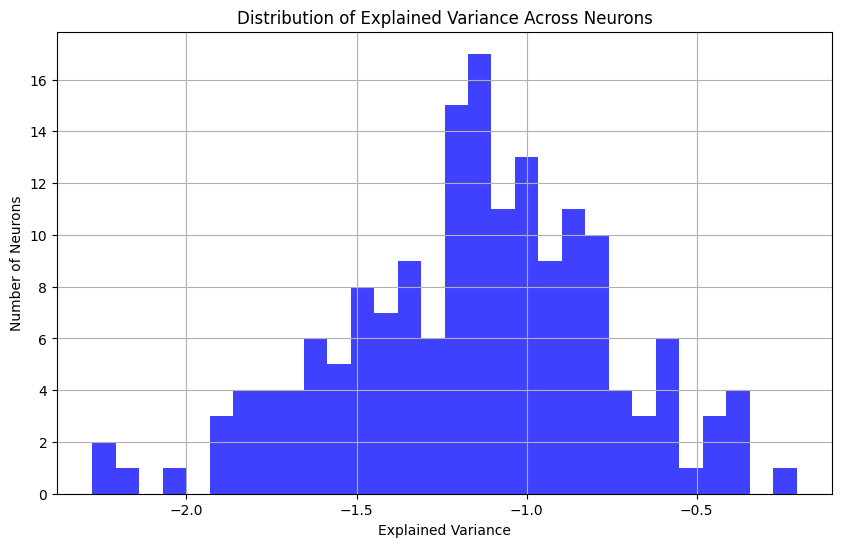

Average correlation coefficient: 0.14668127353562171
Average explained variance: -1.1574376682408594


In [17]:
#### Here your code
from sklearn.metrics import explained_variance_score

explained_variance, corr, r2, mse = calculate_metrics(spikes_val,y_pred_ridge)
# Plotting the distribution of explained variance
plt.figure(figsize=(10, 6))
plt.hist(explained_variance, bins=30, alpha=0.75, color='blue')
plt.title('Distribution of Explained Variance Across Neurons')
plt.xlabel('Explained Variance')
plt.ylabel('Number of Neurons')
plt.grid(True)
plt.show()

# Print average metrics
print("Average correlation coefficient:", np.nanmean(corr))
print("Average explained variance:", np.mean(explained_variance))

##### Predicting from pixels is very hard and the model is likely to overfit. An image is very high-dimensional, try to retain the corresponding 1000 PCs and use them to predict the neural activity. 

In [18]:
#### Here your code
x_flat_tr = x_train.reshape(x_train.shape[0],-1)
x_flat_te = x_test.reshape(x_test.shape[0],-1)
    
# performing PCA
pca = PCA(n_components=1000)
X_train_pca = pca.fit_transform(x_flat_tr)
X_test_pca = pca.transform(x_flat_te)
#X_tr = np.hstack([np.ones((X_train_reduced.shape[0],1)), X_train_reduced])
#X_te = np.hstack([np.ones((X_test_reduced.shape[0],1)), X_test_reduced])

y_pred_pca, error_pca, r2_pca = ridge_reg(X_train_pca, y_train, X_test_pca, y_test)


In [19]:
print("Overall error of the model reduced by PCA:", np.sum(error_pca))

Overall error of the model reduced by PCA: 25.100933


##### Can we improve the prediction? Using the ridge regression, find the best parameter with cross-fold validation (remember to split the data keeping the same distribution of classes between the train and validation set). Does it get better?

In [23]:
#### Here your code
def cross_validation(x_tr, y_tr, x_te, y_te):
    # Split the training data again for internal validation
    x_train, x_val, y_train, y_val = train_test_split(x_tr, y_tr, test_size=0.3, random_state=42)
    
    # Define the model and set up the grid search
    model = Ridge()
    parameter_grid = {'alpha': [0.1, 1, 10, 100, 1000]}
    grid_search = GridSearchCV(model, parameter_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

    # Fit the grid search model on the internal training set
    grid_search.fit(x_train, y_train)

    # Get the best model from grid search
    best_model = grid_search.best_estimator_

    # Predict on the external test data using the best model
    y_pred_test = best_model.predict(x_te)
    mse_test = np.mean((y_te-y_pred_test)**2, axis=0)
    r2_test = r2_score(y_te, y_pred_test)

    # Predict on the internal validation data for comparison
    y_pred_val = best_model.predict(x_val)
    mse_val = np.mean((y_val-y_pred_val)**2, axis=0)
    r2_val = r2_score(y_val, y_pred_val)

    return {
        'test_mse': mse_test,
        'test_r2': r2_test,
        'validation_mse': mse_val,
        'validation_r2': r2_val,
        'best_params': grid_search.best_params_,
        'prediction':y_pred_test
    }

x_tr, x_te = preprocessing_func(x_train, x_test)
results = cross_validation(x_tr, y_train, x_te, y_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [24]:
print("The mean squared error summed up for all neurons is:",np.sum(results['test_mse']))

The mean squared error summed up for all neurons is: 31.823242346772524


In [26]:
explained_variance, corr, r2, mse = calculate_metrics(spikes_val,results['prediction'])

print(f"Explained var: {round(np.mean(explained_variance),4)}")
print(f"Correlations: {round(np.mean(corr),4)}")
print(f"R2: {round(np.mean(r2),4)}")
print(f"MSE: {round(np.mean(mse),4)}")

Explained var: -0.3913
Correlations: 0.1718
R2: -0.3976
MSE: 0.1894


**Answer:** The results get better but marginally

### Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool'] 
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it? 
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

In [11]:
import torch
import torchvision.models as models
from torchvision.models import ResNet50_Weights
from scipy.stats import pearsonr
from sklearn.metrics import explained_variance_score
import pickle

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
######################################## Section 1+2: Implementation 1 #############################################

# Load the pre-trained ResNet50 model
weights = ResNet50_Weights.IMAGENET1K_V1  # This is equivalent to pretrained=True in previous versions
model = models.resnet50(weights=weights)

# Set the model to evaluation mode
model.eval()

# extracting the activations from the layers
layers = ['conv1','layer1','layer2','layer3','layer4','avgpool']

# Define a function to hook the activations
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
        print(f"Activations of {name} stored!")
    return hook

# Register hooks
model.conv1.register_forward_hook(get_activation('conv1'))
model.layer1.register_forward_hook(get_activation('layer1'))
model.layer2.register_forward_hook(get_activation('layer2'))
model.layer3.register_forward_hook(get_activation('layer3'))
model.layer4.register_forward_hook(get_activation('layer4'))
model.avgpool.register_forward_hook(get_activation('avgpool'))

with torch.no_grad():
    output = model(torch.tensor(x_train, dtype=torch.float32)).to(device)
    
for layer in layers:
    pca_model = PCA(n_components=1000)
    pca_model.fit(activations[layer].reshape(x_train.shape[0], -1).numpy())
    activations[layer] = pca_model.transform(activations[layer].reshape(x_train.shape[0], -1).numpy())

# save the PCAs of the activations
with open('layer_activations_pca_1.pkl', 'wb') as f:
        pickle.dump(activations, f)

In [ ]:
######################################## Section 1+2: Implementation 2 #############################################
# Load the pre-trained ResNet50 model
weights = ResNet50_Weights.IMAGENET1K_V1  # This is equivalent to pretrained=True in previous versions
model = models.resnet50(weights=weights)

# extracting the activations from the layers
layers = ['conv1','layer1','layer2','layer3','layer4','avgpool']

# Define a function to hook the activations
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Set the model to evaluation mode
model.eval()

# Since dataset is big we split it into batches
def batch_process_images(x_tr, batch_size=100):
    # Process images in batches
    for i in range(0, len(x_tr), batch_size):
        batch = x_train[i:i + batch_size]
        imgs = torch.stack([torch.tensor(img) for img in batch])
        yield imgs
        
# Retrieving batches and fitting 

pca_models = {}
activations_train = {}
for layer_name in layers:
    handle = getattr(model, layer_name).register_forward_hook(get_activation(layer_name))
    acts = []
    for imgs in batch_process_images(x_train):
        with torch.no_grad():
            output = model(imgs)
        acts.append(activations[layer_name])
    activations_total = torch.cat(acts,axis=0)
    pca_model = PCA(n_components=1000)
    pca_model.fit(activations_total.reshape(x_train.shape[0], -1).numpy())
    activations_train[layer_name] = pca_model.transform(activations_total.reshape(x_train.shape[0], -1).numpy())
    pca_models[layer_name] = pca_model
    print(f"Finished computing PCAs for layer {layer_name}")
    handle.remove()  

# save the PCAs of the activations for training set
with open('train_layer_activations_pca.pkl', 'wb') as f:
    pickle.dump(activations_train, f)

In [ ]:
activations_val = {}
for layer_name in layers:
    handle = getattr(model, layer_name).register_forward_hook(get_activation(layer_name))
    with torch.no_grad():
        output = model(torch.tensor(x_test, dtype=torch.float32))
    activations_val[layer_name] = pca_models[layer_name].transform(activations[layer_name].reshape(x_test.shape[0], -1).numpy())
    handle.remove()

# save the PCAs of the activations for validation set
with open('val_layer_activations_pca.pkl', 'wb') as f:
    pickle.dump(activations_val, f)   
    
# save the model
torch.save(model, 'model_week6_1.pth')

In [12]:
# Define the path to the pickle file and load them

file_path_1 = 'train_layer_activations_pca.pkl'
# Open the pickle file in binary read mode
with open(file_path_1, 'rb') as file:
    # Load the dictionary from the file
    activations_train = pickle.load(file)

file_path_2 = 'val_layer_activations_pca.pkl'
# Open the pickle file in binary read mode
with open(file_path_2, 'rb') as file:
    # Load the dictionary from the file
    activations_val = pickle.load(file)


In [15]:
################################################# Section 3 ####################################################
r2_scores = []
errors = []
layers = ['conv1','layer1','layer2','layer3','layer4','avgpool']
neural_predictions = np.zeros((len(layers),y_test.shape[0],y_test.shape[1]))
# Retrieving batches and fitting 
for i, layer_name in enumerate(layers):
    prediction, mse, r2 = ridge_reg(activations_train[layer_name], y_train, activations_val[layer_name], y_test)
    errors.append(mse)
    r2_scores.append(r2)
    neural_predictions[i,:,:] = prediction

<Figure size 1200x1200 with 0 Axes>

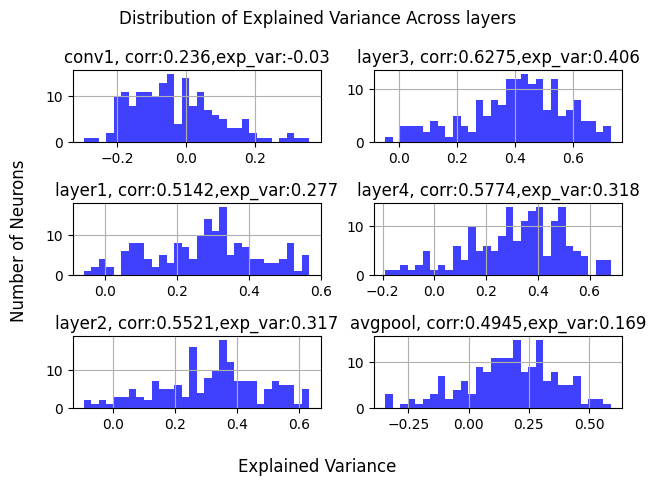

In [25]:
goodness_of_fit = {}
for j, layer_name in enumerate(layers):
    explained_variance, corr, r2, mse = calculate_metrics(y_test,neural_predictions[j])
    goodness_of_fit[layer_name] = {'correlation': round(np.nanmean(corr),4), 'explained_variance': explained_variance, 'mse': mse}
    
# Plotting the distribution of explained variance
plt.figure(figsize=(12, 12))
fig, ax = plt.subplots(3,2)
for i,layer_name in enumerate(layers):
    axi = ax[int(i%3),int(i//3)]
    axi.hist(goodness_of_fit[layer_name]['explained_variance'], bins=30, alpha=0.75, color='blue')
    axi.set_title(f"{layer_name}, corr:{goodness_of_fit[layer_name]['correlation']},exp_var:{round(np.mean(goodness_of_fit[layer_name]['explained_variance']),3)}")
    axi.grid(True)

fig.suptitle('Distribution of Explained Variance Across layers')
fig.supxlabel('Explained Variance')
fig.supylabel('Number of Neurons')
fig.tight_layout()
plt.show()


In [33]:
goodness_of_fit

{'conv1': {'correlation': 0.236,
  'explained_variance': array([-0.11274481,  0.05171927, -0.1335137 ,  0.05297713, -0.04241944,
         -0.13323121,  0.05017175, -0.04049013, -0.01182172,  0.06750944,
          0.00168124, -0.13826605,  0.03458493, -0.16880349, -0.12504562,
         -0.21450757,  0.02735726, -0.16686516, -0.01070376, -0.05251377,
          0.01654487, -0.10680621, -0.04453463, -0.04236796, -0.12391482,
         -0.06126079, -0.00468727, -0.14382742, -0.16533535, -0.04261897,
         -0.18068449, -0.19706994, -0.19818919, -0.11007067, -0.20524659,
         -0.13188731, -0.15484712, -0.15956205, -0.20925132, -0.00161619,
         -0.09249936, -0.04976045, -0.00041961, -0.09765224, -0.03788888,
          0.02449529, -0.11523833, -0.13666368, -0.19014711, -0.13653419,
          0.00898573, -0.05359543,  0.07937966, -0.29676812, -0.07504805,
         -0.16772632, -0.01678059, -0.07886042, -0.11567474, -0.16945058,
         -0.08744147, -0.16863594, -0.01115929, -0.105784

**Answer:** Yes, the explained variance and correlation are significantly higher with the activations from 'layer3' predicting the neural activity the best.

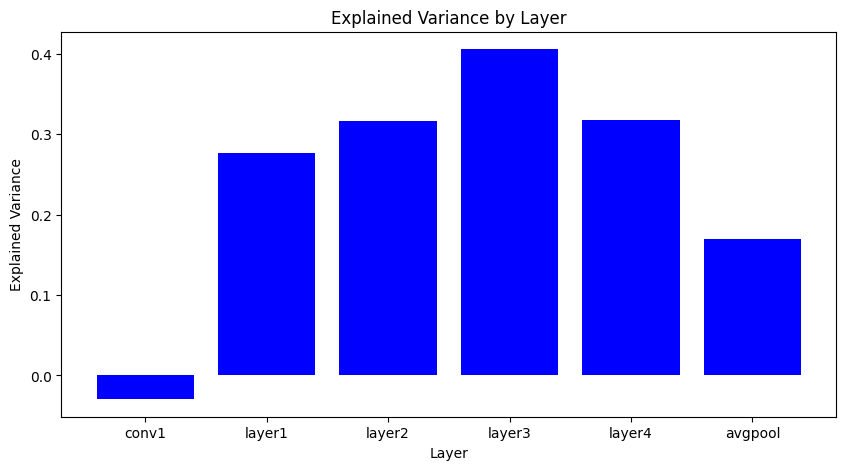

In [37]:
################################################# Section 5 ########################################################
# Extract explained variance for each layer and order by network depth
layers_ordered = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']
explained_variances = [np.mean(goodness_of_fit[layer]['explained_variance']) for layer in layers_ordered]

plt.figure(figsize=(10, 5))
plt.bar(layers_ordered, explained_variances, color='blue')
plt.xlabel('Layer')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Layer')
plt.show()

**Answer:** The predicted neural activity across layers resembles a normal distribution, which peaks at layer 3. This is due to the model being the most expressive in the middle, since the layer likely contains the largest number of parameters (or the largest number of potentially relevant features). We then project the results onto a lower dimensional space by performing PCA. 

In [21]:
################################################# Section 6 ####################################################
# Load a randomly initialized ResNet50
model_random = models.resnet50(weights=None)
model_random.eval()  # Set the model to evaluation mode

###################### We have selected layer1 for comparing random and pre-trained models #########################
# Define a function to hook the activations
activations_random = {}
def get_activation(name):
    def hook(model_random, input, output):
        activations_random[name] = output.detach()
        print(f"Activations of {name} stored!")
    return hook

# Register hooks
model_random.layer3.register_forward_hook(get_activation('layer3'))
layer_name = 'layer3'

activations_train_random = {}
# Extracting PCAs of activations
handle = getattr(model_random, layer_name).register_forward_hook(get_activation('layer3'))
with torch.no_grad():
    output = model_random(torch.tensor(x_train, dtype=torch.float32)).to(device)
pca_model_random = PCA(n_components=1000)
pca_model_random.fit(activations_random['layer3'].reshape(x_train.shape[0], -1).numpy())
activations_train_random['layer3'] = pca_model_random.transform(activations_random['layer3'].reshape(x_train.shape[0], -1).numpy())
handle.remove()

# save the PCAs of the activations for train set
with open('train_random_activations_pca.pkl', 'wb') as f:
    pickle.dump(activations_train_random, f) 

Activations of layer3 stored!
Activations of layer3 stored!


In [23]:
activations_val_random = {}
handle = getattr(model_random, layer_name).register_forward_hook(get_activation('layer3'))
with torch.no_grad():
    output = model_random(torch.tensor(x_test, dtype=torch.float32))
activations_val_random['layer3'] = pca_model_random.transform(activations_random['layer3'].reshape(x_test.shape[0], -1).numpy())
handle.remove()

# save the PCAs of the activations for train set
with open('val_random_activations_pca.pkl', 'wb') as f:
    pickle.dump(activations_val_random, f) 

# Fitting and predicting
neural_predictions_random, mse_random, r2_random = ridge_reg(activations_train_random['layer3'], y_train, activations_val_random['layer3'], y_test)

Activations of layer3 stored!
Activations of layer3 stored!


In [26]:
# Compare metrics for layer 3
comparison_model = {}
#exp_var_pretrained,__ = explained_varaince_score(neural_predictions[3].flatten(), y_test.flatten())
#exp_var_random,__ = explained_varaince_score(neural_predictions_random.flatten(), y_test.flatten())

explained_variance_pretrained, correlations_pretrained, r2_pretrained, mse_pretrained = calculate_metrics(y_test,neural_predictions[3])
explained_variance_random, correlations_random, r2_random, mse_random = calculate_metrics(y_test,neural_predictions_random)

comparison_model['pretrained'] = [round(np.mean(explained_variance_pretrained),4), round(np.mean(correlations_pretrained),4), round(np.mean(mse_pretrained),4)]
comparison_model['random'] = [round(np.mean(explained_variance_random),4), round(np.mean(correlations_random),4), round(np.mean(mse_random),4)]

print(comparison_model)

{'pretrained': [0.4059, 0.6275, 0.0733], 'random': [0.1562, 0.4184, 0.1132]}


**Answer:** Neural activity is better predicted by the pre-trained ResNet50 model. This might be due to the fact that the inductive bias of a pre-trained model aligns better with human neural activity recorded on images of objects. It is possible that the inductive bias of artificial neural networks trained on similar objects and the inductive bias of a human neural network are similar. 